In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from classes import MixedNaiveBayes

from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (
    auc,
    accuracy_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
from sklearn.utils.class_weight import compute_class_weight

import time

seed = 777

In [3]:
import pickle

(train_X_folds, train_y_folds, test_X_folds, test_y_folds, feature_names_folds, reverse_map_folds) = pickle.load(open('data/prepared_data.pkl', 'rb'))

In [4]:
train_X = train_X_folds[0]
train_y = train_y_folds[0]
test_X = test_X_folds[0]
test_y = test_y_folds[0]
feature_names = feature_names_folds[0]
reverse_map = reverse_map_folds[0]

### Naive Bayes

In [ ]:
# Test MixedNaiveBayes with class balancing
print("=== MixedNaiveBayes with Class Balancing ===")

# Train MixedNaiveBayes with balanced classes
print("Training MixedNaiveBayes with balanced classes...")
start_time = time.time()

mixed_nb = MixedNaiveBayes(class_weight='balanced')
mixed_nb.fit(train_X, train_y)
mixed_nb_training_time = time.time() - start_time

mixed_nb_pred = mixed_nb.predict(test_X)

# Calculate accuracy
mixed_nb_accuracy = accuracy_score(test_y, mixed_nb_pred)

print(f"MixedNaiveBayes Training time: {mixed_nb_training_time:.2f} seconds")
print(f"MixedNaiveBayes Accuracy: {mixed_nb_accuracy:.4f}")

# Get prediction probabilities for ROC analysis
mixed_nb_proba = mixed_nb.predict_proba(test_X)
mixed_nb_positive_proba = mixed_nb_proba[:, 1]  # Probability of positive class


=== MixedNaiveBayes with Class Balancing ===
Training MixedNaiveBayes with balanced classes...
MixedNaiveBayes Training time: 1.29 seconds
MixedNaiveBayes Prediction time: 0.0718 seconds
MixedNaiveBayes Accuracy: 0.6188


In [7]:
# MixedNaiveBayes Performance Analysis
print("\n=== MixedNaiveBayes Performance Analysis ===")

# ROC Curve and AUC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(test_y, mixed_nb_positive_proba)
roc_auc_nb = auc(fpr_nb, tpr_nb)

print(f"MixedNaiveBayes AUC: {roc_auc_nb:.4f}")

# Confusion matrix
mixed_nb_cm = confusion_matrix(test_y, mixed_nb_pred)
print("\nMixedNaiveBayes Confusion Matrix:")
print("                 Predicted")
print("                No Readmit  Readmit")
print(f"Actual No Readmit    {mixed_nb_cm[0,0]:6d}    {mixed_nb_cm[0,1]:6d}")
print(f"Actual Readmit        {mixed_nb_cm[1,0]:6d}    {mixed_nb_cm[1,1]:6d}")

# Calculate metrics
mixed_nb_tn, mixed_nb_fp, mixed_nb_fn, mixed_nb_tp = mixed_nb_cm.ravel()
mixed_nb_precision = mixed_nb_tp / (mixed_nb_tp + mixed_nb_fp) if (mixed_nb_tp + mixed_nb_fp) > 0 else 0
mixed_nb_recall = mixed_nb_tp / (mixed_nb_tp + mixed_nb_fn) if (mixed_nb_tp + mixed_nb_fn) > 0 else 0
mixed_nb_f1 = 2 * (mixed_nb_precision * mixed_nb_recall) / (mixed_nb_precision + mixed_nb_recall) if (mixed_nb_precision + mixed_nb_recall) > 0 else 0

print(f"\nMixedNaiveBayes Performance Metrics:")
print(f"Accuracy:  {mixed_nb_accuracy:.4f}")
print(f"Precision: {mixed_nb_precision:.4f}")
print(f"Recall:    {mixed_nb_recall:.4f}")
print(f"F1-Score:  {mixed_nb_f1:.4f}")
print(f"AUC:       {roc_auc_nb:.4f}")



=== MixedNaiveBayes Performance Analysis ===
MixedNaiveBayes AUC: 0.5917

MixedNaiveBayes Confusion Matrix:
                 Predicted
                No Readmit  Readmit
Actual No Readmit     11473      6636
Actual Readmit          1154      1171

MixedNaiveBayes Performance Metrics:
Accuracy:  0.6188
Precision: 0.1500
Recall:    0.5037
F1-Score:  0.2311
AUC:       0.5917


### SVM

In [8]:
# SGDClassifier for Linear SVM with ROC Curve and AUC
print("\n=== SGDClassifier Linear SVM ===")

# Train SGDClassifier with hinge loss (equivalent to SVM)
print("Training SGDClassifier with hinge loss (Linear SVM)...")
start_time = time.time()

sgd_svm = SGDClassifier(
    loss='hinge',           # Hinge loss = SVM
    max_iter=1000,
    random_state=seed,
    class_weight='balanced',
    learning_rate='optimal'
)

sgd_svm.fit(train_X, train_y)
sgd_training_time = time.time() - start_time

# Make predictions and get decision scores
sgd_pred = sgd_svm.predict(test_X)
sgd_decision_scores = sgd_svm.decision_function(test_X)

# Calculate accuracy
sgd_accuracy = accuracy_score(test_y, sgd_pred)

print(f"SGD SVM Training time: {sgd_training_time:.2f} seconds")
print(f"SGD SVM Accuracy: {sgd_accuracy:.4f}")


=== SGDClassifier Linear SVM ===
Training SGDClassifier with hinge loss (Linear SVM)...
SGD SVM Training time: 7.29 seconds
SGD SVM Accuracy: 0.6736



=== ROC Curve and AUC Analysis ===
SGD SVM AUC: 0.6678


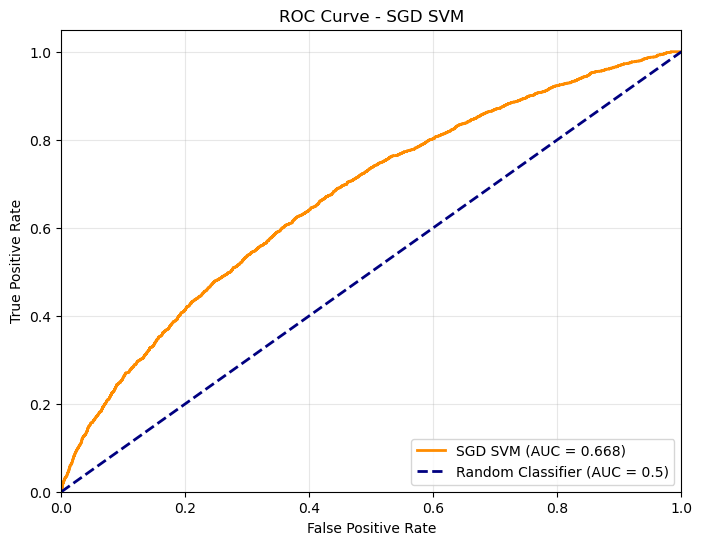


=== SGD SVM Performance Analysis ===
SGD SVM Confusion Matrix:
                 Predicted
                No Readmit  Readmit
Actual No Readmit     12496      5613
Actual Readmit          1056      1269

SGD SVM Performance Metrics:
Accuracy:  0.6736
Precision: 0.1844
Recall:    0.5458
F1-Score:  0.2757
AUC:       0.6678


In [9]:
# ROC Curve and AUC
print("\n=== ROC Curve and AUC Analysis ===")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_y, sgd_decision_scores)
roc_auc = auc(fpr, tpr)

print(f"SGD SVM AUC: {roc_auc:.4f}")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'SGD SVM (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', 
         label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SGD SVM')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# SGD SVM Performance Analysis
print(f"\n=== SGD SVM Performance Analysis ===")

# Confusion matrix
sgd_cm = confusion_matrix(test_y, sgd_pred)
print("SGD SVM Confusion Matrix:")
print("                 Predicted")
print("                No Readmit  Readmit")
print(f"Actual No Readmit    {sgd_cm[0,0]:6d}    {sgd_cm[0,1]:6d}")
print(f"Actual Readmit        {sgd_cm[1,0]:6d}    {sgd_cm[1,1]:6d}")

# Calculate metrics
sgd_tn, sgd_fp, sgd_fn, sgd_tp = sgd_cm.ravel()
sgd_precision = sgd_tp / (sgd_tp + sgd_fp) if (sgd_tp + sgd_fp) > 0 else 0
sgd_recall = sgd_tp / (sgd_tp + sgd_fn) if (sgd_tp + sgd_fn) > 0 else 0
sgd_f1 = 2 * (sgd_precision * sgd_recall) / (sgd_precision + sgd_recall) if (sgd_precision + sgd_recall) > 0 else 0

print(f"\nSGD SVM Performance Metrics:")
print(f"Accuracy:  {sgd_accuracy:.4f}")
print(f"Precision: {sgd_precision:.4f}")
print(f"Recall:    {sgd_recall:.4f}")
print(f"F1-Score:  {sgd_f1:.4f}")
print(f"AUC:       {roc_auc:.4f}")

In [10]:
# Calculate standard deviation for each feature
feature_std = np.std(train_X, axis=0)

# Get raw coefficients
raw_coef = sgd_svm.coef_[0]

# Calculate adjusted feature importance: coefficient * std_dev (preserve direction)
feature_importance_with_direction = raw_coef * feature_std

# Use absolute values for sorting, but preserve direction in output
feature_importance_abs = np.abs(feature_importance_with_direction)

# Get top 20 most important features (sorted by absolute importance)
top_indices = np.argsort(feature_importance_abs)[:-21:-1]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance_with_direction[top_indices]  # Keep original direction
top_importance_abs = feature_importance_abs[top_indices]  # For magnitude reference

print(f"\nTop 30 Most Important Features (Std-Adjusted with Direction):")
print("Positive = increases readmission risk, Negative = decreases readmission risk")
for i, (feature, importance, importance_abs) in enumerate(zip(top_features, top_importance, top_importance_abs)):
    direction = "+" if importance >= 0 else "-"
    print(f"{i+1:2d}. {feature}: {direction}{importance_abs:.4f}")


Top 30 Most Important Features (Std-Adjusted with Direction):
Positive = increases readmission risk, Negative = decreases readmission risk
 1. number_inpatient: +0.4946
 2. discharge_disposition_id_11: -0.3036
 3. discharge_disposition_id_22: +0.2339
 4. discharge_disposition_id_3: +0.2276
 5. discharge_disposition_id_5: +0.1586
 6. diag_PC7: +0.1283
 7. diag_PC1: +0.1236
 8. discharge_disposition_id_2: +0.1193
 9. diag_PC19: +0.1125
10. age_[80-90): +0.1071
11. discharge_disposition_id_6: +0.0998
12. admission_source_id_17: -0.0987
13. gender_Male x age_[60-70): +0.0819
14. discharge_disposition_id_18: +0.0760
15. time_in_hospital: +0.0753
16. age_[60-70): +0.0725
17. diag_PC40: +0.0656
18. discharge_disposition_id_28: +0.0623
19. diag_PC35: +0.0611
20. A1Cresult_>8: -0.0606


In [ ]:
print("\n=== RBF Kernel SVM ===")

# Train RBF SVM with balanced classes
print("Training RBF SVM with balanced classes...")
start_time = time.time()

rbf_svm = SVC(
    kernel='rbf',
    C=1.0,
    gamma='scale',
    class_weight='balanced',
    random_state=seed,
    verbose=True
)

rbf_svm.fit(train_X, train_y)
rbf_training_time = time.time() - start_time

# Make predictions
start_time = time.time()
rbf_pred = rbf_svm.predict(test_X)
rbf_prediction_time = time.time() - start_time

# Calculate accuracy
rbf_accuracy = accuracy_score(test_y, rbf_pred)

print(f"RBF Training time: {rbf_training_time:.2f} seconds")
print(f"RBF Prediction time: {rbf_prediction_time:.4f} seconds")
print(f"RBF SVM Accuracy: {rbf_accuracy:.4f}")


In [ ]:
# RBF SVM Performance Analysis
print("\n=== RBF SVM Performance Analysis ===")

# Classification report
print("RBF SVM Classification Report:")
print(classification_report(test_y, rbf_pred))

# Confusion matrix in table form
print("\nRBF SVM Confusion Matrix:")
rbf_cm = confusion_matrix(test_y, rbf_pred)
print("                 Predicted")
print("                No Readmit  Readmit")
print(f"Actual No Readmit    {rbf_cm[0,0]:6d}    {rbf_cm[0,1]:6d}")
print(f"Actual Readmit        {rbf_cm[1,0]:6d}    {rbf_cm[1,1]:6d}")

# Calculate metrics
rbf_tn, rbf_fp, rbf_fn, rbf_tp = rbf_cm.ravel()
rbf_precision = rbf_tp / (rbf_tp + rbf_fp) if (rbf_tp + rbf_fp) > 0 else 0
rbf_recall = rbf_tp / (rbf_tp + rbf_fn) if (rbf_tp + rbf_fn) > 0 else 0
rbf_f1 = 2 * (rbf_precision * rbf_recall) / (rbf_precision + rbf_recall) if (rbf_precision + rbf_recall) > 0 else 0

# Compare with Linear SVM
print(f"\n=== Linear vs RBF SVM Comparison ===")
print(f"Metric           Linear SVM    RBF SVM")
print(f"Accuracy:       {sgd_accuracy:.4f}      {rbf_accuracy:.4f}")
print(f"Precision:      {sgd_precision:.4f}      {rbf_precision:.4f}")
print(f"Recall:         {sgd_recall:.4f}      {rbf_recall:.4f}")
print(f"F1-Score:       {sgd_f1:.4f}      {rbf_f1:.4f}")
print(f"Training Time:  {sgd_training_time:.2f}s        {rbf_training_time:.2f}s")


### Decision Tree

In [11]:
print("=== Decision Tree with Class Balancing ===")
print("Training Decision Tree with balanced classes...")
start_time = time.time()

dt_model = DecisionTreeClassifier(
    random_state=seed,
    class_weight='balanced',
    max_depth=10,  # Limit depth to prevent overfitting
    min_samples_split=20,  # Minimum samples to split
    min_samples_leaf=10,   # Minimum samples in leaf
    max_features='sqrt'    # Use sqrt of features for each split
)

dt_model.fit(train_X, train_y)
dt_training_time = time.time() - start_time

# Make predictions
start_time = time.time()
dt_pred = dt_model.predict(test_X)
dt_prediction_time = time.time() - start_time

# Calculate accuracy
dt_accuracy = accuracy_score(test_y, dt_pred)

print(f"Decision Tree Training time: {dt_training_time:.2f} seconds")
print(f"Decision Tree Prediction time: {dt_prediction_time:.4f} seconds")
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")

# Get prediction probabilities for ROC analysis
dt_proba = dt_model.predict_proba(test_X)
dt_positive_proba = dt_proba[:, 1]  # Probability of positive class


=== Decision Tree with Class Balancing ===
Training Decision Tree with balanced classes...
Decision Tree Training time: 0.72 seconds
Decision Tree Prediction time: 0.0085 seconds
Decision Tree Accuracy: 0.5108


In [12]:
# Decision Tree Performance Analysis
print("\n=== Decision Tree Performance Analysis ===")

# ROC Curve and AUC
fpr_dt, tpr_dt, thresholds_dt = roc_curve(test_y, dt_positive_proba)
roc_auc_dt = auc(fpr_dt, tpr_dt)

print(f"Decision Tree AUC: {roc_auc_dt:.4f}")

# Confusion matrix
dt_cm = confusion_matrix(test_y, dt_pred)
print("\nDecision Tree Confusion Matrix:")
print("                 Predicted")
print("                No Readmit  Readmit")
print(f"Actual No Readmit    {dt_cm[0,0]:6d}    {dt_cm[0,1]:6d}")
print(f"Actual Readmit        {dt_cm[1,0]:6d}    {dt_cm[1,1]:6d}")

# Calculate metrics
dt_tn, dt_fp, dt_fn, dt_tp = dt_cm.ravel()
dt_precision = dt_tp / (dt_tp + dt_fp) if (dt_tp + dt_fp) > 0 else 0
dt_recall = dt_tp / (dt_tp + dt_fn) if (dt_tp + dt_fn) > 0 else 0
dt_f1 = 2 * (dt_precision * dt_recall) / (dt_precision + dt_recall) if (dt_precision + dt_recall) > 0 else 0

print(f"\nDecision Tree Performance Metrics:")
print(f"Accuracy:  {dt_accuracy:.4f}")
print(f"Precision: {dt_precision:.4f}")
print(f"Recall:    {dt_recall:.4f}")
print(f"F1-Score:  {dt_f1:.4f}")
print(f"AUC:       {roc_auc_dt:.4f}")

# Feature importance analysis
print(f"\n=== Decision Tree Feature Importance ===")
feature_importance = dt_model.feature_importances_

# Get top 20 most important features
top_indices = np.argsort(feature_importance)[:-21:-1]
top_features = [feature_names[i] for i in top_indices]
top_importance = feature_importance[top_indices]

print(f"\nTop 20 Most Important Features:")
for i, (feature, importance) in enumerate(zip(top_features, top_importance)):
    print(f"{i+1:2d}. {feature}: {importance:.4f}")

# Tree structure analysis
print(f"\n=== Decision Tree Structure ===")
print(f"Tree depth: {dt_model.get_depth()}")
print(f"Number of leaves: {dt_model.get_n_leaves()}")
print(f"Number of features used: {np.sum(feature_importance > 0)}")



=== Decision Tree Performance Analysis ===
Decision Tree AUC: 0.5816

Decision Tree Confusion Matrix:
                 Predicted
                No Readmit  Readmit
Actual No Readmit      9003      9106
Actual Readmit           891      1434

Decision Tree Performance Metrics:
Accuracy:  0.5108
Precision: 0.1361
Recall:    0.6168
F1-Score:  0.2229
AUC:       0.5816

=== Decision Tree Feature Importance ===

Top 20 Most Important Features:
 1. number_inpatient: 0.1440
 2. discharge_disposition_id_11: 0.0399
 3. diag_PC5: 0.0296
 4. number_diagnoses: 0.0258
 5. diag_PC143: 0.0204
 6. diag_PC88: 0.0151
 7. diag_PC12: 0.0126
 8. diag_PC54: 0.0123
 9. diag_PC74: 0.0112
10. diag_PC26: 0.0110
11. diag_PC155: 0.0106
12. diag_PC66: 0.0101
13. diag_PC142: 0.0099
14. diag_PC105: 0.0099
15. diag_PC160: 0.0097
16. diag_PC184: 0.0093
17. diag_PC166: 0.0092
18. diag_PC131: 0.0092
19. diag_PC60: 0.0086
20. diag_PC51: 0.0085

=== Decision Tree Structure ===
Tree depth: 10
Number of leaves: 382
Number 

### Random Forest

In [13]:
print("=== Random Forest with Class Balancing ===")
print("Training Random Forest with balanced classes...")
start_time = time.time()

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,  # Limit depth to prevent overfitting
    min_samples_split=20,  # Minimum samples to split
    min_samples_leaf=10,   # Minimum samples in leaf
    max_features='sqrt',   # Use sqrt of features for each split
    class_weight='balanced',
    random_state=seed,
    n_jobs=-1  # Use all available cores
)

rf_model.fit(train_X, train_y)
rf_training_time = time.time() - start_time

# Make predictions
start_time = time.time()
rf_pred = rf_model.predict(test_X)
rf_prediction_time = time.time() - start_time

# Calculate accuracy
rf_accuracy = accuracy_score(test_y, rf_pred)

print(f"Random Forest Training time: {rf_training_time:.2f} seconds")
print(f"Random Forest Prediction time: {rf_prediction_time:.4f} seconds")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

# Get prediction probabilities for ROC analysis
rf_proba = rf_model.predict_proba(test_X)
rf_positive_proba = rf_proba[:, 1]  # Probability of positive class


=== Random Forest with Class Balancing ===
Training Random Forest with balanced classes...
Random Forest Training time: 9.09 seconds
Random Forest Prediction time: 0.0651 seconds
Random Forest Accuracy: 0.7364


In [14]:
# Random Forest Performance Analysis
print("\n=== Random Forest Performance Analysis ===")

# ROC Curve and AUC
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_y, rf_positive_proba)
roc_auc_rf = auc(fpr_rf, tpr_rf)

print(f"Random Forest AUC: {roc_auc_rf:.4f}")

# Confusion matrix
rf_cm = confusion_matrix(test_y, rf_pred)
print("\nRandom Forest Confusion Matrix:")
print("                 Predicted")
print("                No Readmit  Readmit")
print(f"Actual No Readmit    {rf_cm[0,0]:6d}    {rf_cm[0,1]:6d}")
print(f"Actual Readmit        {rf_cm[1,0]:6d}    {rf_cm[1,1]:6d}")

# Calculate metrics
rf_tn, rf_fp, rf_fn, rf_tp = rf_cm.ravel()
rf_precision = rf_tp / (rf_tp + rf_fp) if (rf_tp + rf_fp) > 0 else 0
rf_recall = rf_tp / (rf_tp + rf_fn) if (rf_tp + rf_fn) > 0 else 0
rf_f1 = 2 * (rf_precision * rf_recall) / (rf_precision + rf_recall) if (rf_precision + rf_recall) > 0 else 0

print(f"\nRandom Forest Performance Metrics:")
print(f"Accuracy:  {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")
print(f"AUC:       {roc_auc_rf:.4f}")

# Feature importance analysis
print(f"\n=== Random Forest Feature Importance ===")
feature_importance_rf = rf_model.feature_importances_

# Get top 20 most important features
top_indices_rf = np.argsort(feature_importance_rf)[:-21:-1]
top_features_rf = [feature_names[i] for i in top_indices_rf]
top_importance_rf = feature_importance_rf[top_indices_rf]

print(f"\nTop 20 Most Important Features:")
for i, (feature, importance) in enumerate(zip(top_features_rf, top_importance_rf)):
    print(f"{i+1:2d}. {feature}: {importance:.4f}")

# Random Forest structure analysis
print(f"\n=== Random Forest Structure ===")
print(f"Number of estimators: {rf_model.n_estimators}")
print(f"Max depth: {rf_model.max_depth}")
print(f"Number of features used: {np.sum(feature_importance_rf > 0)}")
print(f"Average number of features per tree: {rf_model.max_features}")



=== Random Forest Performance Analysis ===
Random Forest AUC: 0.6399

Random Forest Confusion Matrix:
                 Predicted
                No Readmit  Readmit
Actual No Readmit     14135      3974
Actual Readmit          1412       913

Random Forest Performance Metrics:
Accuracy:  0.7364
Precision: 0.1868
Recall:    0.3927
F1-Score:  0.2532
AUC:       0.6399

=== Random Forest Feature Importance ===

Top 20 Most Important Features:
 1. number_inpatient: 0.0968
 2. discharge_disposition_id_11: 0.0224
 3. discharge_disposition_id_22: 0.0201
 4. diag_PC1: 0.0180
 5. number_emergency: 0.0164
 6. number_diagnoses: 0.0112
 7. num_medications: 0.0110
 8. diag_PC5: 0.0101
 9. diag_PC0: 0.0100
10. time_in_hospital: 0.0088
11. diag_PC19: 0.0081
12. discharge_disposition_id_3: 0.0077
13. diag_PC68: 0.0075
14. diag_PC7: 0.0072
15. diag_PC18: 0.0072
16. diag_PC72: 0.0068
17. diag_PC16: 0.0067
18. diag_PC143: 0.0064
19. diag_PC27: 0.0064
20. diag_PC31: 0.0058

=== Random Forest Structure ===

In [ ]:
# Model Comparison: Decision Tree vs Random Forest
print("\n=== Decision Tree vs Random Forest Comparison ===")
print(f"Metric                Decision Tree    Random Forest")
print(f"Accuracy:            {dt_accuracy:.4f}         {rf_accuracy:.4f}")
print(f"Precision:           {dt_precision:.4f}         {rf_precision:.4f}")
print(f"Recall:              {dt_recall:.4f}         {rf_recall:.4f}")
print(f"F1-Score:            {dt_f1:.4f}         {rf_f1:.4f}")
print(f"AUC:                 {roc_auc_dt:.4f}         {roc_auc_rf:.4f}")
print(f"Training Time:       {dt_training_time:.2f}s         {rf_training_time:.2f}s")
print(f"Prediction Time:     {dt_prediction_time:.4f}s     {rf_prediction_time:.4f}s")

# Feature importance comparison
print(f"\n=== Feature Importance Comparison ===")
print("Top 10 features comparison between Decision Tree and Random Forest:")
print("Rank  Decision Tree Feature          Random Forest Feature")
print("-" * 70)

for i in range(10):
    dt_feature = top_features[i] if i < len(top_features) else "N/A"
    rf_feature = top_features_rf[i] if i < len(top_features_rf) else "N/A"
    print(f"{i+1:2d}.   {dt_feature:<30} {rf_feature}")

# Check if the same features are important in both models
common_features = set(top_features[:10]) & set(top_features_rf[:10])
print(f"\nCommon important features (top 10): {len(common_features)}")
if common_features:
    print("Common features:", list(common_features))


### Optimized Random Forest

In [ ]:
# Hyperparameter tuning for Random Forest
print("=== Random Forest Hyperparameter Optimization ===")

# Define focused parameter grid for faster optimization
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [15, 20, None],
    'min_samples_split': [10, 20],
    'max_features': ['sqrt', 0.3],
    'class_weight': ['balanced', 'balanced_subsample']
}

# Create base Random Forest
rf_base = RandomForestClassifier(
    random_state=seed,
    n_jobs=-1
)

# Grid search with cross-validation
print("Performing GridSearchCV...")
print(f"Total combinations: {2*3*2*2*2} = 48 combinations")
start_time = time.time()

grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,  # 3-fold CV for faster computation
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(train_X, train_y)
grid_search_time = time.time() - start_time

print(f"Grid search completed in: {grid_search_time:.2f} seconds")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Get the best model
rf_optimized = grid_search.best_estimator_


In [ ]:
# Evaluate optimized Random Forest
print("\n=== Optimized Random Forest Evaluation ===")

# Make predictions with optimized model
start_time = time.time()
rf_opt_pred = rf_optimized.predict(test_X)
rf_opt_prediction_time = time.time() - start_time

# Calculate accuracy
rf_opt_accuracy = accuracy_score(test_y, rf_opt_pred)

# Get prediction probabilities for ROC analysis
rf_opt_proba = rf_optimized.predict_proba(test_X)
rf_opt_positive_proba = rf_opt_proba[:, 1]

print(f"Optimized Random Forest Prediction time: {rf_opt_prediction_time:.4f} seconds")
print(f"Optimized Random Forest Accuracy: {rf_opt_accuracy:.4f}")

# ROC Curve and AUC
fpr_rf_opt, tpr_rf_opt, thresholds_rf_opt = roc_curve(test_y, rf_opt_positive_proba)
roc_auc_rf_opt = auc(fpr_rf_opt, tpr_rf_opt)

print(f"Optimized Random Forest AUC: {roc_auc_rf_opt:.4f}")

# Confusion matrix
rf_opt_cm = confusion_matrix(test_y, rf_opt_pred)
print("\nOptimized Random Forest Confusion Matrix:")
print("                 Predicted")
print("                No Readmit  Readmit")
print(f"Actual No Readmit    {rf_opt_cm[0,0]:6d}    {rf_opt_cm[0,1]:6d}")
print(f"Actual Readmit        {rf_opt_cm[1,0]:6d}    {rf_opt_cm[1,1]:6d}")

# Calculate metrics
rf_opt_tn, rf_opt_fp, rf_opt_fn, rf_opt_tp = rf_opt_cm.ravel()
rf_opt_precision = rf_opt_tp / (rf_opt_tp + rf_opt_fp) if (rf_opt_tp + rf_opt_fp) > 0 else 0
rf_opt_recall = rf_opt_tp / (rf_opt_tp + rf_opt_fn) if (rf_opt_tp + rf_opt_fn) > 0 else 0
rf_opt_f1 = 2 * (rf_opt_precision * rf_opt_recall) / (rf_opt_precision + rf_opt_recall) if (rf_opt_precision + rf_opt_recall) > 0 else 0

print(f"\nOptimized Random Forest Performance Metrics:")
print(f"Accuracy:  {rf_opt_accuracy:.4f}")
print(f"Precision: {rf_opt_precision:.4f}")
print(f"Recall:    {rf_opt_recall:.4f}")
print(f"F1-Score:  {rf_opt_f1:.4f}")
print(f"AUC:       {roc_auc_rf_opt:.4f}")

### XGBoost

In [15]:
print("=== XGBoost with Class Balancing ===")
print("Training XGBoost with balanced classes...")
start_time = time.time()

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(train_y[train_y==0])/len(train_y[train_y==1]),  # Handle class imbalance
    random_state=seed,
    n_jobs=-1,
    eval_metric='logloss'
)

xgb_model.fit(train_X, train_y)
xgb_training_time = time.time() - start_time

# Make predictions
start_time = time.time()
xgb_pred = xgb_model.predict(test_X)
xgb_prediction_time = time.time() - start_time

# Calculate accuracy
xgb_accuracy = accuracy_score(test_y, xgb_pred)

print(f"XGBoost Training time: {xgb_training_time:.2f} seconds")
print(f"XGBoost Prediction time: {xgb_prediction_time:.4f} seconds")
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Get prediction probabilities for ROC analysis
xgb_proba = xgb_model.predict_proba(test_X)
xgb_positive_proba = xgb_proba[:, 1]  # Probability of positive class


=== XGBoost with Class Balancing ===
Training XGBoost with balanced classes...
XGBoost Training time: 2.40 seconds
XGBoost Prediction time: 0.0106 seconds
XGBoost Accuracy: 0.6971


In [16]:
print("\n=== XGBoost Performance Analysis ===")

# ROC Curve and AUC
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(test_y, xgb_positive_proba)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

print(f"XGBoost AUC: {roc_auc_xgb:.4f}")

# Confusion matrix
xgb_cm = confusion_matrix(test_y, xgb_pred)
print("\nXGBoost Confusion Matrix:")
print("                 Predicted")
print("                No Readmit  Readmit")
print(f"Actual No Readmit    {xgb_cm[0,0]:6d}    {xgb_cm[0,1]:6d}")
print(f"Actual Readmit        {xgb_cm[1,0]:6d}    {xgb_cm[1,1]:6d}")

# Calculate metrics
xgb_tn, xgb_fp, xgb_fn, xgb_tp = xgb_cm.ravel()
xgb_precision = xgb_tp / (xgb_tp + xgb_fp) if (xgb_tp + xgb_fp) > 0 else 0
xgb_recall = xgb_tp / (xgb_tp + xgb_fn) if (xgb_tp + xgb_fn) > 0 else 0
xgb_f1 = 2 * (xgb_precision * xgb_recall) / (xgb_precision + xgb_recall) if (xgb_precision + xgb_recall) > 0 else 0

print(f"\nXGBoost Performance Metrics:")
print(f"Accuracy:  {xgb_accuracy:.4f}")
print(f"Precision: {xgb_precision:.4f}")
print(f"Recall:    {xgb_recall:.4f}")
print(f"F1-Score:  {xgb_f1:.4f}")
print(f"AUC:       {roc_auc_xgb:.4f}")

# Feature importance analysis
print(f"\n=== XGBoost Feature Importance ===")
feature_importance_xgb = xgb_model.feature_importances_

# Get top 20 most important features
top_indices_xgb = np.argsort(feature_importance_xgb)[:-21:-1]
top_features_xgb = [feature_names[i] for i in top_indices_xgb]
top_importance_xgb = feature_importance_xgb[top_indices_xgb]

print(f"\nTop 20 Most Important Features:")
for i, (feature, importance) in enumerate(zip(top_features_xgb, top_importance_xgb)):
    print(f"{i+1:2d}. {feature}: {importance:.4f}")

# XGBoost structure analysis
print(f"\n=== XGBoost Structure ===")
print(f"Number of estimators: {xgb_model.n_estimators}")
print(f"Max depth: {xgb_model.max_depth}")
print(f"Learning rate: {xgb_model.learning_rate}")
print(f"Scale pos weight: {xgb_model.scale_pos_weight:.2f}")
print(f"Number of features used: {np.sum(feature_importance_xgb > 0)}")



=== XGBoost Performance Analysis ===
XGBoost AUC: 0.6628

XGBoost Confusion Matrix:
                 Predicted
                No Readmit  Readmit
Actual No Readmit     13061      5048
Actual Readmit          1141      1184

XGBoost Performance Metrics:
Accuracy:  0.6971
Precision: 0.1900
Recall:    0.5092
F1-Score:  0.2767
AUC:       0.6628

=== XGBoost Feature Importance ===

Top 20 Most Important Features:
 1. number_inpatient: 0.0248
 2. discharge_disposition_id_22: 0.0184
 3. discharge_disposition_id_11: 0.0137
 4. discharge_disposition_id_3: 0.0115
 5. diag_PC1: 0.0092
 6. discharge_disposition_id_5: 0.0086
 7. number_emergency: 0.0082
 8. discharge_disposition_id_2: 0.0056
 9. diag_PC140: 0.0054
10. discharge_disposition_id_28: 0.0053
11. number_diagnoses: 0.0051
12. diag_PC43: 0.0050
13. diag_PC35: 0.0049
14. age_[50-60): 0.0049
15. diag_PC28: 0.0049
16. diag_PC19: 0.0048
17. discharge_disposition_id_6: 0.0047
18. medical_specialty_Family/GeneralPractice: 0.0047
19. metformin_

In [17]:
# Optimized XGBoost with Hyperparameter Tuning
print("\n=== XGBoost Hyperparameter Optimization ===")

# Define focused parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Create base XGBoost
xgb_base = xgb.XGBClassifier(
    scale_pos_weight=len(train_y[train_y==0])/len(train_y[train_y==1]),
    random_state=seed,
    n_jobs=-1,
    eval_metric='logloss'
)

# Grid search with cross-validation
print("Performing XGBoost GridSearchCV...")
print(f"Total combinations: {2*3*3*2*2} = 72 combinations")
start_time = time.time()

xgb_grid_search = GridSearchCV(
    estimator=xgb_base,
    param_grid=xgb_param_grid,
    cv=3,  # 3-fold CV for faster computation
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

xgb_grid_search.fit(train_X, train_y)
xgb_grid_search_time = time.time() - start_time

print(f"XGBoost Grid search completed in: {xgb_grid_search_time:.2f} seconds")
print(f"Best XGBoost parameters: {xgb_grid_search.best_params_}")
print(f"Best XGBoost cross-validation score: {xgb_grid_search.best_score_:.4f}")

# Get the best XGBoost model
xgb_optimized = xgb_grid_search.best_estimator_



=== XGBoost Hyperparameter Optimization ===
Performing XGBoost GridSearchCV...
Total combinations: 72 = 72 combinations
Fitting 3 folds for each of 72 candidates, totalling 216 fits
XGBoost Grid search completed in: 381.39 seconds
Best XGBoost parameters: {'colsample_bytree': 0.9, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.8}
Best XGBoost cross-validation score: 0.6711


In [18]:
# Evaluate optimized XGBoost
print("\n=== Optimized XGBoost Evaluation ===")

# Make predictions with optimized XGBoost
start_time = time.time()
xgb_opt_pred = xgb_optimized.predict(test_X)
xgb_opt_prediction_time = time.time() - start_time

# Calculate accuracy
xgb_opt_accuracy = accuracy_score(test_y, xgb_opt_pred)

# Get prediction probabilities for ROC analysis
xgb_opt_proba = xgb_optimized.predict_proba(test_X)
xgb_opt_positive_proba = xgb_opt_proba[:, 1]

print(f"Optimized XGBoost Prediction time: {xgb_opt_prediction_time:.4f} seconds")
print(f"Optimized XGBoost Accuracy: {xgb_opt_accuracy:.4f}")

# ROC Curve and AUC
fpr_xgb_opt, tpr_xgb_opt, thresholds_xgb_opt = roc_curve(test_y, xgb_opt_positive_proba)
roc_auc_xgb_opt = auc(fpr_xgb_opt, tpr_xgb_opt)

print(f"Optimized XGBoost AUC: {roc_auc_xgb_opt:.4f}")

# Confusion matrix
xgb_opt_cm = confusion_matrix(test_y, xgb_opt_pred)
print("\nOptimized XGBoost Confusion Matrix:")
print("                 Predicted")
print("                No Readmit  Readmit")
print(f"Actual No Readmit    {xgb_opt_cm[0,0]:6d}    {xgb_opt_cm[0,1]:6d}")
print(f"Actual Readmit        {xgb_opt_cm[1,0]:6d}    {xgb_opt_cm[1,1]:6d}")

# Calculate metrics
xgb_opt_tn, xgb_opt_fp, xgb_opt_fn, xgb_opt_tp = xgb_opt_cm.ravel()
xgb_opt_precision = xgb_opt_tp / (xgb_opt_tp + xgb_opt_fp) if (xgb_opt_tp + xgb_opt_fp) > 0 else 0
xgb_opt_recall = xgb_opt_tp / (xgb_opt_tp + xgb_opt_fn) if (xgb_opt_tp + xgb_opt_fn) > 0 else 0
xgb_opt_f1 = 2 * (xgb_opt_precision * xgb_opt_recall) / (xgb_opt_precision + xgb_opt_recall) if (xgb_opt_precision + xgb_opt_recall) > 0 else 0

print(f"\nOptimized XGBoost Performance Metrics:")
print(f"Accuracy:  {xgb_opt_accuracy:.4f}")
print(f"Precision: {xgb_opt_precision:.4f}")
print(f"Recall:    {xgb_opt_recall:.4f}")
print(f"F1-Score:  {xgb_opt_f1:.4f}")
print(f"AUC:       {roc_auc_xgb_opt:.4f}")

# Feature importance for optimized model
print(f"\n=== Optimized XGBoost Feature Importance ===")
feature_importance_xgb_opt = xgb_optimized.feature_importances_

# Get top 20 most important features
top_indices_xgb_opt = np.argsort(feature_importance_xgb_opt)[:-21:-1]
top_features_xgb_opt = [feature_names[i] for i in top_indices_xgb_opt]
top_importance_xgb_opt = feature_importance_xgb_opt[top_indices_xgb_opt]

print(f"\nTop 20 Most Important Features (Optimized XGBoost):")
for i, (feature, importance) in enumerate(zip(top_features_xgb_opt, top_importance_xgb_opt)):
    print(f"{i+1:2d}. {feature}: {importance:.4f}")

# Cross-validation analysis for optimized XGBoost
print(f"\n=== Cross-Validation Analysis (Optimized XGBoost) ===")
xgb_cv_scores = cross_val_score(xgb_optimized, train_X, train_y, cv=5, scoring='roc_auc')
print(f"5-Fold CV AUC Scores: {xgb_cv_scores}")
print(f"Mean CV AUC: {xgb_cv_scores.mean():.4f} (+/- {xgb_cv_scores.std() * 2:.4f})")



=== Optimized XGBoost Evaluation ===
Optimized XGBoost Prediction time: 0.0308 seconds
Optimized XGBoost Accuracy: 0.6737
Optimized XGBoost AUC: 0.6733

Optimized XGBoost Confusion Matrix:
                 Predicted
                No Readmit  Readmit
Actual No Readmit     12465      5644
Actual Readmit          1024      1301

Optimized XGBoost Performance Metrics:
Accuracy:  0.6737
Precision: 0.1873
Recall:    0.5596
F1-Score:  0.2807
AUC:       0.6733

=== Optimized XGBoost Feature Importance ===

Top 20 Most Important Features (Optimized XGBoost):
 1. number_inpatient: 0.0328
 2. discharge_disposition_id_22: 0.0185
 3. discharge_disposition_id_3: 0.0153
 4. diag_PC1: 0.0122
 5. discharge_disposition_id_11: 0.0105
 6. discharge_disposition_id_5: 0.0091
 7. number_diagnoses: 0.0078
 8. number_emergency: 0.0074
 9. race_AfricanAmerican x age_[70-80): 0.0065
10. medical_specialty_ObstetricsandGynecology: 0.0064
11. time_in_hospital: 0.0062
12. discharge_disposition_id_2: 0.0061
13. di